In [ ]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


import numpy as np

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

Path to git repo: /home/matias/Documents/PhD/code


# Import real Data

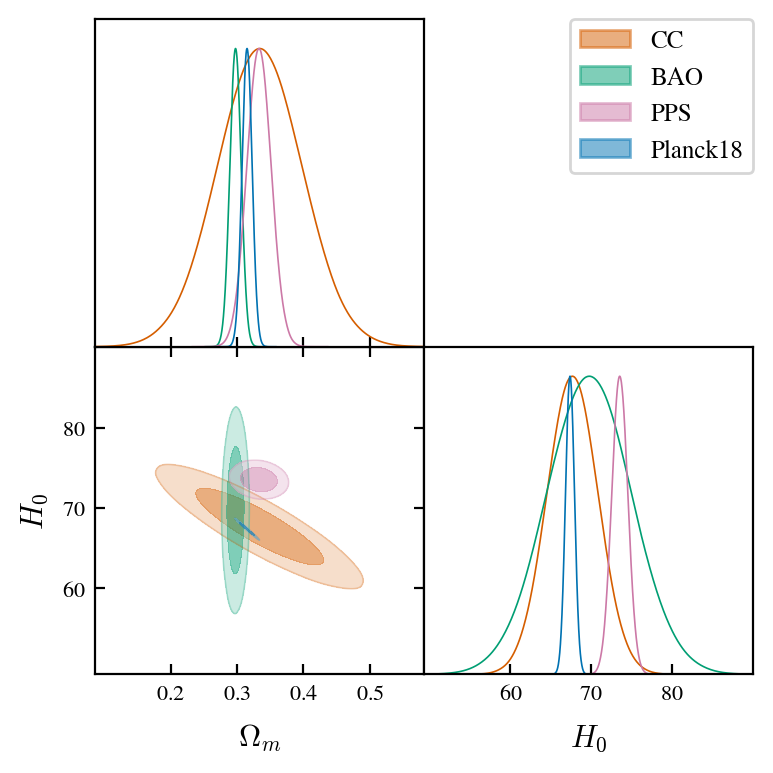

In [4]:
"""
Datasets:
    A: Cosmic Chronometers (CC)
    B: Planck 2018
    C: DESI DR2
    D: PPS
"""

# ----------------------------------------------------------------------
# Load original chains from GetDist outputs
# ----------------------------------------------------------------------
source_dir = os.path.join(path_git, "multimeter", "source")

chain_A_raw = getdist.mcsamples.loadMCSamples(
    file_root=os.path.join(source_dir, "lcdm_cc/lcdm_cc"),
    no_cache=True,
    settings={
        "loglikes": True,
        "names": "CC",
        "label": "CC",
        "ignore_rows": "0.3",
    },
)

chain_B_raw = getdist.mcsamples.loadMCSamples(
    file_root=os.path.join(source_dir, "lcdm_planck/lcdm_planck"),
    no_cache=True,
    settings={
        "loglikes": True,
        "names": "Planck18",
        "label": "Planck18",
        "ignore_rows": "0.3",
    },
)

chain_C_raw = getdist.mcsamples.loadMCSamples(
    file_root=os.path.join(source_dir, "lcdm_desi_dr2/lcdm_desi_dr2"),
    no_cache=True,
    settings={
        "loglikes": True,
        "names": "DESI DR2",
        "label": "DESI DR2",
        "ignore_rows": "0.3",
    },
)

chain_D_raw = getdist.mcsamples.loadMCSamples(
    file_root=os.path.join(source_dir, "lcdm_pps/lcdm_pps"),
    no_cache=True,
    settings={
        "names": "PPS",
        "label": "PPS",
        "ignore_rows": "0.3",
    },
)

# ----------------------------------------------------------------------
# Shared parameters and Gaussian approximation
# ----------------------------------------------------------------------
param_names = ["Omega_m", "H0"]  # shared parameters
names = param_names
labels = [r"\Omega_m", r"H_0"]

# Means and covariances from the original chains
mean_A_0 = chain_A_raw.mean(param_names)
mean_B_0 = chain_B_raw.mean(param_names)
mean_C_0 = chain_C_raw.mean(param_names)
mean_D_0 = chain_D_raw.mean(param_names)

cov_A_0 = chain_A_raw.cov(param_names)
cov_B_0 = chain_B_raw.cov(param_names)
cov_C_0 = chain_C_raw.cov(param_names)
cov_D_0 = chain_D_raw.cov(param_names)

# Draw Gaussian approximations to the 2D posteriors
n_samples = int(1e6)
samps_A = np.random.multivariate_normal(mean_A_0, cov_A_0, size=n_samples)
samps_B = np.random.multivariate_normal(mean_B_0, cov_B_0, size=n_samples)
samps_C = np.random.multivariate_normal(mean_C_0, cov_C_0, size=n_samples)
samps_D = np.random.multivariate_normal(mean_D_0, cov_D_0, size=n_samples)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label="Dataset A")
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label="Dataset B")
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label="Dataset C")
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label="Dataset D")

# ----------------------------------------------------------------------
# Triangle plot
# ----------------------------------------------------------------------
colors = [
    "#D55E00",  # dark orange
    "#009E73",  # green/teal
    "#CC79A7",  # soft magenta
    "#0072B2",  # blue (colorblind-friendly)
]

g = plots.get_subplot_plotter()
g.triangle_plot(
    [chain_A, chain_C, chain_D, chain_B],
    filled=True,
    contour_args={"alpha": 0.5},
    contour_colors=colors,
    legend_labels=["CC", "BAO", "PPS", "Planck18"],
    labels=[r"$\Omega_m$", r"$H_0$"],
)

output_dir = os.path.join(path_global, "multimeter", "notebooks", "paper_plots", "figures")
os.makedirs(output_dir, exist_ok=True)

g.export(os.path.join(output_dir, "dist_data_tot.png"))
g.export(os.path.join(output_dir, "dist_data_tot.pdf"))
g.export(os.path.join(output_dir, "dist_data_tot.svg"))

plt.show()
